In [1]:
import pandas as pd
import numpy as np

# 데이터 시각화 패키지
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# 가설검정 및 통계 분석 패키지
from scipy import stats

# 선형모델 formula ( y ~ x1 + x2 + ...)
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

from sklearn.linear_model import LinearRegression
from statsmodels.api import qqplot, add_constant

from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.anova import anova_lm

# 변수 선택법(후진제거법)
from sklearn.feature_selection import RFE

# 다중공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Scale변환 -> 표준화 회귀계수 산출
## coefficient를 표준화해서 비교해본다.
from sklearn.preprocessing import StandardScaler

# grhpviz
from sklearn.tree import export_graphviz

import graphviz

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import GridSearchCV


# 주피터 노트북 사용시 그래프 자동 출력 옵션
%matplotlib inline

matplotlib.rc('font', family = "NanumGothic")
plt.rc('font', family = "NanumGothic")
plt.rcParams["font.family"] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

## 의사결정나무_예측
- 콘크리트 강도를 예측하는 의사결정나무 모델
- prediction method를 이용해 예측값 구하기
- mse와 mae 산출 후 비교

### 1) 데이터 구성

In [2]:
df_raw = pd.read_csv("./Data/Concrete.csv")
df_raw.head()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   cement              1030 non-null   float64
 1   blast_furnace_slag  1030 non-null   float64
 2   fly_ash             1030 non-null   float64
 3   water               1030 non-null   float64
 4   superplasticizer    1030 non-null   float64
 5   coarse_aggregate    1030 non-null   float64
 6   fine_aggregate      1030 non-null   float64
 7   age                 1030 non-null   int64  
 8   strength            1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [35]:
# 설명 변수, 목표변수 분리
df_raw_x = df_raw.drop("strength", axis=1, inplace = False)
df_raw_y = df_raw["strength"]

In [36]:
# train_test_split (6:4로 트레인과 테스트 데이터 나누기)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, 
                                                                test_size=0.4, random_state=1234)

print("train data X size: {}".format(df_train_x.shape))
print("train data Y size: {}".format(df_train_y.shape))
print("test data X size: {}".format(df_test_x.shape))
print("test data Y size: {}".format(df_test_y.shape))

train data X size: (618, 8)
train data Y size: (618,)
test data X size: (412, 8)
test data Y size: (412,)


In [37]:
# parameter 조정 전 설명력 확인
tree_uncustomized = DecisionTreeRegressor(random_state=1234)
tree_uncustomized.fit(df_train_x, df_train_y)

# Train 데이터 설명력
print("Score on training set: {:.3f}".format(tree_uncustomized.score(df_train_x, df_train_y)))

#test데이터 설명력
print("Score on test set: {:.3f}".format(tree_uncustomized.score(df_test_x, df_test_y)))

Score on training set: 0.996
Score on test set: 0.790


※ training set에 과적합이 발생한 것으로 보인다. 따라서 과적합을 
해결할 수 있도록 모델의 파라미터를 조절할 필요가 있어보인다.

## 2) 최적 파라미터 찾기

In [38]:
estimator = DecisionTreeRegressor()

# 리프 노드 수
para_leaf = [n_leaf * 1 for n_leaf in range(1, 20)]
# 스플릿 최소 자료 수
para_split = [n_leaf * 2 for n_leaf in range(2, 20)]
# 트리 깊이
para_depth = [depth for depth in range(1, 10)]


# criterion은 mae와 mse만 비교
param_grid = {"criterion": ["mse" ,"mae"], 
              "max_depth": para_depth, "min_samples_split": para_split, 
              "min_samples_leaf": para_leaf}

grid_dt = GridSearchCV(estimator, param_grid, scoring="r2", n_jobs=-1)
grid_dt.fit(df_train_x, df_train_y)

print("best estimator model: \n{}".format(grid_dt.best_estimator_))
print("best parmater: \n{}".format(grid_dt.best_params_))
print("nbest score: \n{}".format(grid_dt.best_score_.round(3)))

best estimator model: 
DecisionTreeRegressor(max_depth=9, min_samples_leaf=3, min_samples_split=4)
best parmater: 
{'criterion': 'mse', 'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 4}
nbest score: 
0.793


- 의사결정나무의 최적의 모델과 최적의 파라미터는 다음과 같다.
    - 모델 : mse
    - 깊이: 9
    - 최소 이파리 노드: 3
    - 최소 스플릿: 4

## 3)  MSE와 MAE비교
- estimator model을 mae와 mse로 나눠서 각 파라미터를 넣어 확인해보도록 하겠다.

In [40]:
### MSE
mse_tree_final = DecisionTreeRegressor(criterion="mse", min_samples_leaf= 3,
                                       min_samples_split=4, max_depth=9,random_state=1234)
mse_tree_final.fit(df_train_x, df_train_y)

# Train 데이터 설명력
print("MSE Score on training set: {:.3f}".format(mse_tree_final.score(df_train_x, df_train_y)))
#test데이터 설명력
print("MSE Score on test set: {:.3f}".format(mse_tree_final.score(df_test_x, df_test_y)))

print("")
### MAE
mae_tree_final = DecisionTreeRegressor(criterion="mae", min_samples_leaf= 3,
                                       min_samples_split=4, max_depth=9,random_state=1234)
mae_tree_final.fit(df_train_x, df_train_y)

# Train 데이터 설명력
print("MAE Score on training set: {:.3f}".format(mae_tree_final.score(df_train_x, df_train_y)))
#test데이터 설명력
print("MAE Score on test set: {:.3f}".format(mae_tree_final.score(df_test_x, df_test_y)))

MSE Score on training set: 0.954
MSE Score on test set: 0.785

MAE Score on training set: 0.918
MAE Score on test set: 0.808


※ 같은 변수를 줄 지라도 기준(criterion)을 뭐로 잡느 냐에 따라서 성능에 차이가 난다.
- MSE Score의 경우 테스트 데이터의 경우 MAE보다 0.023정도 차이가 난다.
- 따라서 MSE를 활용한 모델을 최종 모델로 선정할 계획이다.

## 4) 최종모델 선정 및 결과

In [56]:
# 최종 모델
mse_tree_final = DecisionTreeRegressor(criterion="mse", min_samples_leaf= 3,
                                       min_samples_split=4, max_depth=9,random_state=1234)
mse_tree_final.fit(df_train_x, df_train_y)
prediction = mse_tree_final.predict(df_test_x)

In [59]:
### 평가함수
from sklearn.metrics import mean_squared_error

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

root_mean_squared_error(df_test_y, prediction).round(3)

7.639

In [51]:
# Train 데이터 설명력
print("MSE Score on training set: {:.3f}".format(mse_tree_final.score(df_train_x, df_train_y)))
#test데이터 설명력
print("MSE Score on test set: {:.3f}".format(mse_tree_final.score(df_test_x, df_test_y)))

MSE Score on training set: 0.954
MSE Score on test set: 0.785


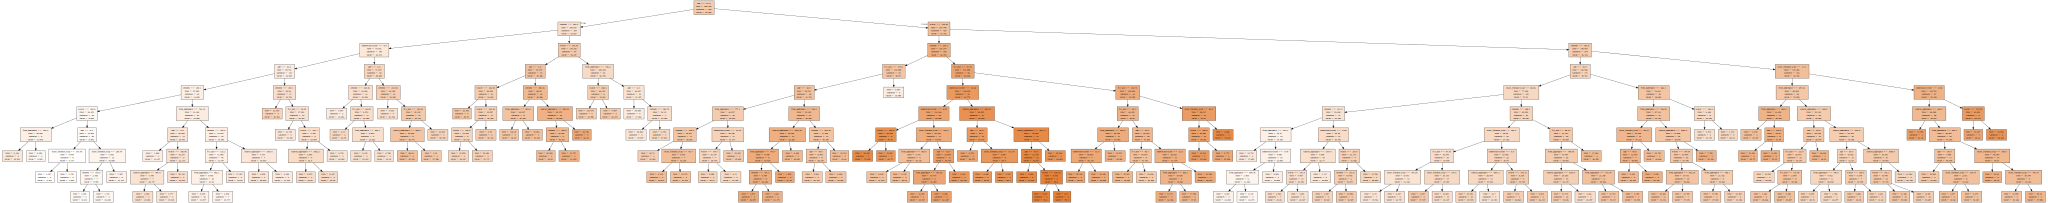

In [46]:
# Decision Tree 생성
v_feature_name = df_train_x.columns
export_graphviz(mse_tree_final, out_file = "tree_leaf.dot", feature_names = v_feature_name,
                impurity=True, filled = True) # filled 색으로 영향력 표시

with open("tree_leaf.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [47]:
# 변수 중요도 확인
df_importance = pd.DataFrame()
df_importance["Feature"]=v_feature_name
df_importance["Importance"] = mse_tree_final.feature_importances_

df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
7,age,0.329
0,cement,0.240
3,water,0.192
2,fly_ash,0.058
4,superplasticizer,0.058
1,blast_furnace_slag,0.054
6,fine_aggregate,0.047
5,coarse_aggregate,0.022


Text(0, 0.5, '변수')

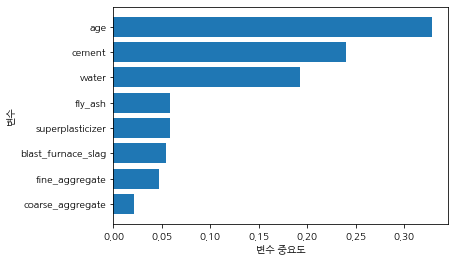

In [48]:
df_importance.sort_values("Importance", ascending= True, inplace=True)
coordinates=range(len(df_importance))
plt.barh(y=coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

- Decision Tree Regressor 모델의 테스트 점수는 0.864로 꽤나 정확한 것으로 보인다.
    - MSE Score on training set: 0.954
    - MSE Score on test set: 0.785
- 초기값    
    - Score on training set: 0.996
    - Score on test set: 0.790
    
- 초기값과 비교해서 보면 training set의 과적합을 0.042 정도 낮췄으나 test set의 정확도는 0.005밖에 낮아지지 않았으므로 파라미터를 적용한 모델이 더 낫다고 보여진다,
    
- 변수 중요도는 age, cement, water 순서라고 할 수 있기에, 시멘트의 강도에 영향을 가장 크게 미치는 변수는 age, cement, water의 양으로 보여진다.

- RMSE는 7.639 정도로 나타난다. (수업 미진행으로 해석 보류)